## Stochastic gradient descent on the mushroom data

<br>

Here is the notebook from the mushroom example for logistic regression. After running the original code, we'll implement SGD to compare it to the results we get with the built-in <code>LogisticRegression</code> function.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/YData123/sds265-fa21/main/demos/classification/mushrooms.csv')
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


A description of these mushroom data can be found [here](https://archive.ics.uci.edu/ml/datasets/Mushroom).

In [3]:
data['class'] = LabelEncoder().fit_transform(data['class'])
encoded_data = pd.get_dummies(data)
encoded_data.head()

,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0



The transformation is mapping each categorical variable to a series of 1-hot or "dummy" variables,
so the weights are meaningful in a logistic regression model.



Next, we convert this DataFrame to numpy arrays, suitable for input to sklearn.

In [5]:
encoded_data.drop?

In [6]:
y = encoded_data['class'].values
X = encoded_data.drop('class',axis=1).values

#### Dimensions of the data

Ok, now before we get to work building a classifier, let's look at some 
of the characteristics of the data. Following code finds
the number of data points, number of predictor variables, the number of
expanded predictors, and percentage of poisonous mushrooms in the data.

In [8]:
num_data_points = X.shape[0] 
num_original_predictors = data.shape[1]-1
num_expanded_predictors = X.shape[1]
poisonous = np.mean(y)*100

print("Number of data points: %d" % num_data_points)
print("Number of original predictors: %d" % num_original_predictors)
print("Number of expanded predictors: %d" % num_expanded_predictors)
print("Percent poisonous: %.1f%%" % poisonous)

Number of data points: 8124
Number of original predictors: 22
Number of expanded predictors: 117
Percent poisonous: 48.2%


#### Fitting logistic regression models

Next, we will construct a series of logistic regression models with an increasing number of training points. Specifically, we will:

* let the sample size $n$ vary from 2 to 400 in increments of 1
* for each $n$ train a logistic regression model on $n$ randomly selected training points, and test on the remaining data
* for each $n$, do this 10 times and average the error rates
* plot the resulting average error rates as a function of $n$

Some notes:

* We will use the function `sklearn.model_selection.train_test_split` in each trial to randomly split the data into training and test sets. For example, you can use `train_test_split(X, y, train_size=n)`
* When $n$ is small, the model will fail to train if all of the training examples have the same label. When this happens, we just skip that data set and choose another random split.
* The implementation only requires about 10-15 lines of code. 

100%|██████████| 39/39 [00:02<00:00, 14.17it/s]


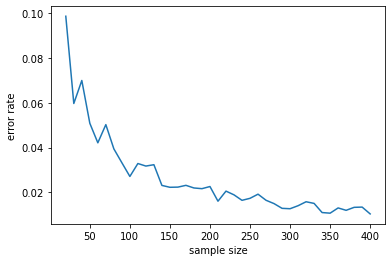

In [12]:
trials = 10
sample_size = np.arange(20, 401, 10)
error_rate = np.zeros(len(sample_size))
lr = LogisticRegression(solver='lbfgs')

from tqdm import tqdm
error_rate = []
lr = LogisticRegression(solver='lbfgs')
for n in tqdm(sample_size):
    err = []
    for trial in np.arange(trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n)
        lr.fit(X_train, y_train)
        this_err = np.mean(lr.predict(X_test) != y_test)
        err.append(this_err)
    error_rate.append(np.mean(err))

plt.plot(sample_size, error_rate)
plt.xlabel('sample size')
_ = plt.ylabel('error rate')

### SGD implementation 

Now let's implement SGD and run this on a subset of the data. We first separate out the training and test data


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=200)
lr.fit(X_train, y_train)
param = lr.coef_[0]
n = X_train.shape[0]


Next we run SGD for a fixed number of steps. In eacjh step, we select a random training point. Then we compute the probability of $Y=1$ for that example and apply the update formula.


In [15]:
import random

beta = 0*param
steps = 100000

delta = .1
for t in range(1,steps):
    i = random.sample(range(n), 1)[0]
    x_i = X_train[i]
    y_i = y_train[i]
    p = 1 / (1 + np.exp(-np.dot(x_i,beta)))
    beta = beta + delta/np.sqrt(t) * (y_i - p) * x_i


Next we'll plot the two sets of parameters for comparison

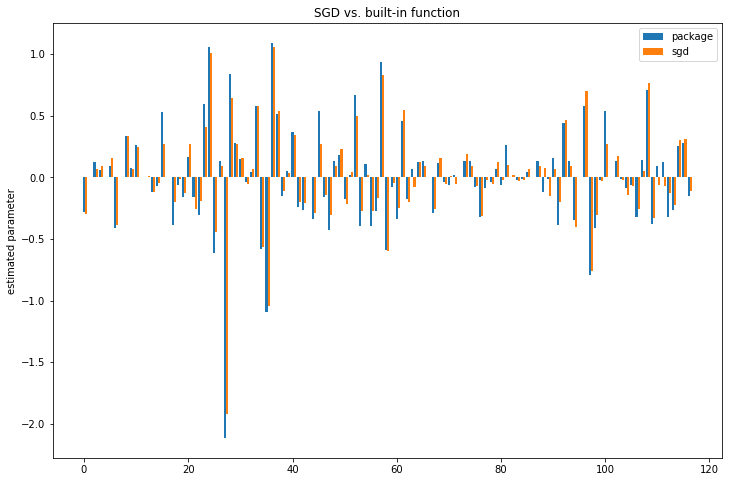

In [16]:
plt.figure(figsize=(12,8))
w = .4

x = np.arange(0, len(param)) 
plt.bar(x, param, width=w, label='package')
plt.bar(x + w, beta, width=w, label='sgd')

plt.ylabel('estimated parameter')
plt.title('SGD vs. built-in function')

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

Now let's run SGD again, this time including a penalty to prevent the coefficients from getting too large. 


In [17]:
beta = 0*param
steps = 100000
loss = []
delta = .1
lambda_reg = 1.0
for t in range(1,steps):
    i = random.sample(range(n), 1)[0]
    x_i = X_train[i]
    y_i = y_train[i]
    p = 1 / (1 + np.exp(-np.dot(x_i,beta)))
    beta = (1-2*lambda_reg*delta/np.sqrt(t)) * beta + delta/np.sqrt(t) * (y_i - p) * x_i


Now we should see that the parameters are "shrunk" toward zero.


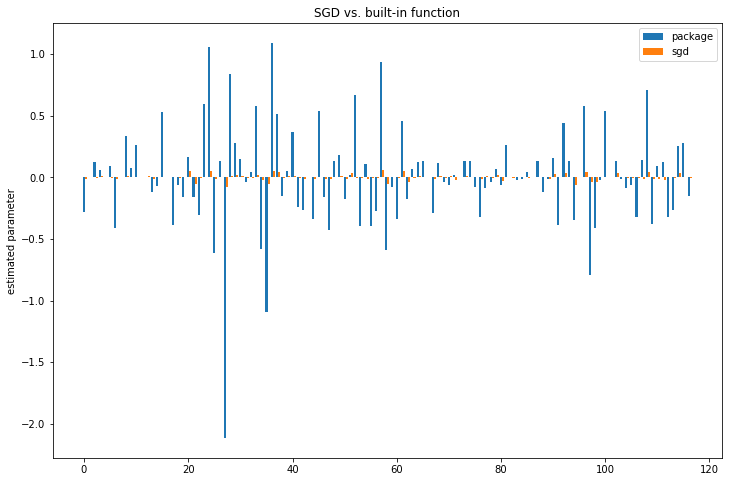

In [18]:
plt.figure(figsize=(12,8))
w = .4

x = np.arange(0, len(param)) 
plt.bar(x, param, width=w, label='package')
plt.bar(x + w, beta, width=w, label='sgd')

plt.ylabel('estimated parameter')
plt.title('SGD vs. built-in function')

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

## Your turn!

Try modifying the code to display the error rate as a function of the step in SGD training. Does the result make sense? Try to explain any fluctuations you see in the the loss function.


